# Import Libraries


In [ ]:
!pip install transformers
!pip install -U sentence-transformers
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 28.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=2c36e8f60b2be0708569a6ad673a4553e423a74dfc98f42f708196802ac7c239
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers
Looking in indexes: https://pypi.o

In [ ]:
import os
import numpy as np
import pandas as pd
import random
import faiss
import time
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import time
from functools import reduce
import math
from pprint import pprint
from cycler import cycler
from sentence_transformers.readers import InputExample
from sentence_transformers import SentenceTransformer, SentencesDataset, losses
import regex as re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from torch.utils.data import DataLoader

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
def set_reproducibility(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"

set_reproducibility(8)

# Dataset Download

In [ ]:
df_doc = pd.read_csv('https://raw.githubusercontent.com/Anna-8/Information-Retrieval/main/doc.csv')
df_doc.head()


,index,document,title
0,1,"Comaromi, J.P. The present study is a history ...",18 Editions of the Dewey Decimal Classifications
1,2,"Slater, M. This report is an analysis of 6300 ...",Use Made of Technical Libraries
2,3,"Wilson, P. The relationships between the organ...",Two Kinds of Power An Essay on Bibliographic C...
3,4,"Buckland, M.K. The establishment of nine new u...",Systems Analysis of a University Library; fina...
4,5,"Brophy, P. Although the use of games in profes...",A Library Management Game: a report on a resea...


In [ ]:
df_qry = pd.read_csv('https://raw.githubusercontent.com/Anna-8/Information-Retrieval/main/qry.csv')
df_qry.head()

,index,query
0,1,What problems and concerns are there in making...
1,2,"How can actually pertinent data, as opposed to..."
2,3,What is information science? Give definitions...
3,4,Image recognition and any other methods of aut...
4,5,What special training will ordinary researcher...


In [ ]:
df_rel = pd.read_csv('https://raw.githubusercontent.com/Anna-8/Information-Retrieval/main/rel.csv')
df_rel.head()

,qry_id,rel_doc
0,1,28
1,1,35
2,1,38
3,1,42
4,1,43


# First approach

We train the model building triplets:
* As anchor we use the title of the document
* As positive we use abstract of the same document
* As negative we use abstract of another random document


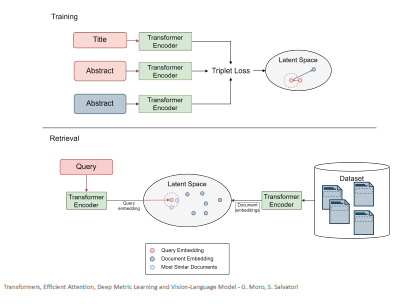

In [ ]:
# define the model
model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [ ]:
# build the dataset as a list of couples text-label
# the text is the doc/title
# the label is id of the doc/title  
train_examples = []

for i in range(df_doc.shape[0]):
  train_examples.append(InputExample(texts= [df_doc["title"][i]], label= df_doc["index"][i]))
  train_examples.append(InputExample(texts= [df_doc["document"][i]], label= df_doc["index"][i]))

# create the dataset
train_dataset = SentencesDataset(train_examples, model)

# define the data loader 
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size= 128)

 We use the ```BatchAllTripletLoss``` provided by the library [Sentence Transformer](https://www.sbert.net/docs/package_reference/losses.html). The BatchAllTripletLoss takes a batch with label-sentence pairs and computes the loss for all possible, valid triplets, i.e., anchor and positive must have the same label, anchor and negative a different label. 

In [ ]:
# define the loss
train_loss = losses.BatchAllTripletLoss(model=model)

In [ ]:
# tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=3, warmup_steps=100)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/23 [00:00<?, ?it/s]

Iteration:   0%|          | 0/23 [00:00<?, ?it/s]

Iteration:   0%|          | 0/23 [00:00<?, ?it/s]

Generate the embeddings of the documents, the titles and the queries in the latent space

In [ ]:
# compute the embeddings 
queries_embeddings = model.encode(df_qry["query"])
docs_embeddings =  model.encode(df_doc["document"])
titles_embeddings = model.encode(df_doc["title"])

## Efficient Retrieval

 Use algorithms provided by the **faiss** library to perform efficient retrieval. To assign the vectors to a particular cluster we assigned indices another and use the L2 distance metric with `IndexFlatL2`.

In [ ]:
d = docs_embeddings.shape[1]
print("Embedding dimension:", d)

Embedding dimension: 768


In [ ]:
# create an Index object for the dataset with the same dimension d of the embeddings
l2_index = faiss.IndexFlatIP(d)
# the ‘is_trained’ flag denotes whether the index is trained 
print("Train flag:", l2_index.is_trained)
# add vectors added to the index object
l2_index.add(docs_embeddings)
# the ‘ntotal’ attribute shows the total number of vectors added to the index object
print("Number of vectors added:", l2_index.ntotal)

Train flag: True
Number of vectors added: 1460


Use the `search` method to perform the retrival search and find the $k$ nearest neighbors  retrieval search. Given the number of queries $Q$ and the number of nearest neighbors $k$, the `search` method returns two results: 
1.   The  `indices` matrix with dimension $Qxk$ which contains, for each query, the indices of $k$ most similar vectors
2.   Thei `distances` matrix with dimension $Qxk$ which contains, for each query, the distances to the $k$ most similar vectors

In [ ]:
# set the number k of similar vectors to be returned 
k = 10
# perform the search and get the indices and distances matrices
distances, indices = l2_index.search(queries_embeddings, k)

Perform the search for `n` queries and check dimensions

In [ ]:
n = 5
print(f"Number of total queries: {df_qry.shape[0]}\n")
print(f"Shape of the distances matrixs: {distances.shape}\n")
print(f"Shape of the indices matrixs:  {indices.shape}\n")
print(f"Indices of the nearest neighbors of the first {n} queries\n{indices[:n]}\n") 
print(f"The distances between the first query and its nearest neighbors are\n{distances[0, :1]}\n")

Number of total queries: 76

Shape of the distances matrixs: (76, 10)

Shape of the indices matrixs:  (76, 10)

Indices of the nearest neighbors of the first 5 queries
[[  57  642  804  477  488   42  599   81  752  652]
 [ 732  564 1137  477  308   77  635 1053 1280  486]
 [  59  468  651   84  645 1168  371  584 1180  598]
 [ 979  308  561  482  178  789  665  314  419  529]
 [ 605  534   96 1098 1095 1080  527 1355   59 1112]]

The distances between the first query and its nearest neighbors are
[193.03656 191.60712 190.83784 187.21648 186.43407 185.92117 184.2135
 181.1392  179.87366 179.5437 ]



Try another type of search: Inverted File Index

In [ ]:
k_prime = 10 # number of voronoi cells
k = 10 # we want to find top-5 nearest neighbors
nprobe = 3 # number of probes, faiss use 1 as default

quantizer = faiss.IndexFlatL2(d) # index that assign embedding to voronoi cells
ivf_index = faiss.IndexIVFFlat(quantizer, d, k_prime) 

In [ ]:
assert not ivf_index.is_trained
ivf_index.train(docs_embeddings)
assert ivf_index.is_trained

In [ ]:
n = 5
ivf_index.nprobe = nprobe
ivf_index.add(docs_embeddings) # add may be slower than the L2 index
distances, indices = ivf_index.search(queries_embeddings, k) # actual search

print(f"Indices of the nearest neighbors of the first {n} queries\n{indices[:n]}\n") 
print(f"The distances between the first query and its nearest neighbors are {distances[0, :1]}\n")

Indices of the nearest neighbors of the first 5 queries
[[ 642   57  428  488   42  491  804  477  652   27]
 [ 564  732  477  486 1280 1154 1137   77  679   56]
 [ 468   59   84  645  651  371  598 1160 1180 1168]
 [ 561  979  419  665  482  308  789  661  314  178]
 [ 534  131 1080   96  655  663   67 1098 1095  155]]

The distances between the first query and its nearest neighbors are [ 99.765076 118.51562  118.597916 121.03638  122.910286 125.671745
 128.11201  131.75192  134.52675  135.51247 ]



In [ ]:
print(f"Results of the L2 index for the first {n} queries\n{indices[:n]}\n") 

Results of the L2 index for the first 5 queries
[[ 642   57  428  488   42  491  804  477  652   27]
 [ 564  732  477  486 1280 1154 1137   77  679   56]
 [ 468   59   84  645  651  371  598 1160 1180 1168]
 [ 561  979  419  665  482  308  789  661  314  178]
 [ 534  131 1080   96  655  663   67 1098 1095  155]]



## Evaluation of results

We consider different kinds of metrics to evaluate the performance of the model. Let's call $TP/FP$ the number of true/false positives and $TN/FN$ the number of true/false negatives. We define:

*   **Precision**: $ P= \frac{TP}{TP+FP}$

*   **Recall**: $ R= \frac{TP}{TP+FN}$

*   **f1-score**: $ F_1 = 2\frac{P\cdot R}{P+R}$

*   **Mean Average Precision**: $MAP = \frac{1}{|Q|}∑_{j=1}^{|Q|} \frac{1}{m_j}\sum_{k=1}^{m_j}Precision(R_{jk})$

* **R-Precision**: Let R be the number of docs relevant for a given query, the R-precision is the number of docs relevant in the first R doc retrived divided by R.

In [ ]:
def precision(queries_id, results, gt):
    precision = []
    for q, r in zip(queries_id, results):
        predicted = df_doc.iloc[r]["index"]
        gt_docs = gt[gt["qry_id"] == q]["rel_doc"].tolist()
        precision.append(len(np.intersect1d(predicted, gt_docs)) / len(predicted))
    return precision

def recall(queries_id, results, gt):
    recall = []
    for q, r in zip(queries_id, results):
        predicted = df_doc.iloc[r]["index"]
        gt_docs = gt[gt["qry_id"] == q]["rel_doc"].tolist()
        recall.append(len(np.intersect1d(predicted, gt_docs)) / len(gt_docs))
    return recall

def f1(queries_id, results, gt):
    prec = precision(queries_id, results, gt)
    rec = recall(queries_id, results, gt)
    return [2 * p * r / (p + r) if p + r >0 else 1 for p, r in zip(prec, rec) ]

def r_precision(queries_id, results, gt):
    r_precision = []
    for q, res in zip(queries_id, results):
        predicted = df_doc.iloc[res]["index"]
        gt_docs = gt[gt["qry_id"] == q]["rel_doc"].tolist()
        r = len(gt_docs)
        r_precision.append(len(np.intersect1d(predicted[:r], gt_docs)) / r)
    return r_precision

def MAP(queries_id, results, gt):
    mean_average_precision = []
    for q, res in zip(queries_id, results):
        gt_docs = gt[gt["qry_id"] == q]["rel_doc"].tolist()
        r = len(gt_docs)
        r_precision = []
        for k in range(1, r + 1):
            r_precision.append(len(np.intersect1d(res[:k], gt_docs)) / k)
        mean_average_precision.append(sum(r_precision) / r)

    return sum(mean_average_precision) / len(queries_id)

In [ ]:
print("Precision:", np.mean(precision(df_qry["index"], indices, df_rel)))
print("Recall:", np.mean(recall(df_qry["index"], indices, df_rel)))
print("F1 score:", np.mean(f1(df_qry["index"], indices, df_rel)))
print("R-precision:", np.mean(r_precision(df_qry["index"], indices, df_rel)))
print("MAP:", np.mean(MAP(df_qry["index"], indices, df_rel)))

Precision: 0.24736842105263154
Recall: 0.08530023084149577
F1 score: 0.33408317341365423
R-precision: 0.08146251154325017
MAP: 0.02910028541434425


# Second approach 

In [ ]:
# split the queries in training and test set 
n_qry =  int(df_qry.shape[0]*0.8)
qry_train = df_qry.iloc[:n_qry,:]
qry_test = df_qry.iloc[n_qry:,:]
print(f"Split of queries: train: {qry_train.shape[0]}, test: {qry_test.shape[0]}\n")

Split of queries: train: 60, test: 16



We define the similarity beetwen a query and a document as: 
* 0.9 if the document is relevant for the query 
* 0.1 otherwise

In [ ]:
def is_similar(query_id, doc_id):
  return 0.9 if query_id in df_rel["qry_id"] and doc_id in list(df_rel[df_rel["qry_id"] == qry_id]["rel_doc"]) else 0.1

We train the model define couples of query-document, the corresponding label defined through the previously defined similarity function. 

In [ ]:
train_samples = []
for qry_id in range(qry_train['index'].shape[0]):
  for doc_id in range(df_doc['index'].shape[0]):
      train_samples.append(
          InputExample(
              texts=[qry_train["query"][qry_id], df_doc["document"][doc_id]],
              label= is_similar(qry_id, doc_id)
              ))

In [ ]:
# define the model 
model = SentenceTransformer('all-MiniLM-L6-v2')
# define the loader 
loader = DataLoader(train_samples, shuffle=True, batch_size=16)
# define the loss as the cosine similarity loss
loss = losses.CosineSimilarityLoss(model)

In [ ]:
# tune the model
model.fit(
    train_objectives=[(loader, loss)],
    epochs=1,
    warmup_steps = 100
)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5475 [00:00<?, ?it/s]

In [ ]:
#compute the embeddings for the documents
docs_embeddings = model.encode(list(df_doc["document"]), convert_to_tensor=True)
#compute the embeddings for the queries
query_embeddings = model.encode(list(qry_test["query"]), convert_to_tensor=True)

## Efficient Retrieval

In [ ]:
d = docs_embeddings.shape[1]
print("Embedding dimension:", d)

Embedding dimension: 384


In [ ]:
# create an Index object for the dataset with the same dimension d of the embeddings
l2_index = faiss.IndexFlatIP(d)
# the ‘is_trained’ flag denotes whether the index is trained 
print("Train flag:", l2_index.is_trained)
# add vectors added to the index object
l2_index.add(docs_embeddings.detach().cpu().numpy())
# the ‘ntotal’ attribute shows the total number of vectors added to the index object
print("Number of vectors added:", l2_index.ntotal)

Train flag: True
Number of vectors added: 1460


In [ ]:
# set the number k of similar vectors to be returned 
k = 10
# perform the search and get the indices and distances matrices
distances, indices = l2_index.search(query_embeddings.detach().cpu().numpy(), k)

## Evaluation of results

In [ ]:
print("Precision:", np.mean(precision(df_qry["index"], indices, df_rel)))
print("Recall:", np.mean(recall(df_qry["index"], indices, df_rel)))
print("F1 score:", np.mean(f1(df_qry["index"], indices, df_rel)))
print("R-precision:", np.mean(r_precision(df_qry["index"], indices, df_rel)))
print("MAP:", np.mean(MAP(df_qry["index"], indices, df_rel)))

Precision: 0.00625
Recall: 0.0078125
F1 score: 0.9444444444444444
R-precision: 0.0078125
MAP: 0.002468711911408831


# Model comparison

|  | Tf-idf | LSA | First  | Second  |
| --- | --- | --- | --- |--- |
| Precision |  0.29 | 0.31 | 0.247 | 0.006| 
| f1-score | 0.27 | 0.27 | 0.33 |  0.94 |
| MAP |  0.06 | 0.07 |  0.029 | 0.0024 |